In [2]:
import uproot
import awkward as ak
import numpy as np

fin = uproot.open("../ZZTo4mu.root")
tree = fin["Events"]

electrons = tree.arrays(filter_name="Electron_*", entry_stop=100_000)
muons = tree.arrays(filter_name="Muon_*", entry_stop=100_000)

# let's build the lepton arrays back into objects 
electrons = ak.zip({k.replace('Electron_', ''): electrons[k] for k in electrons.fields})
muons = ak.zip({k.replace('Muon_', ''): muons[k] for k in muons.fields})

print("Avg. electrons/event:", np.sum(ak.num(electrons)) / tree.num_entries)
print("Avg. muons/event:", np.sum(ak.num(muons)) / tree.num_entries)

Avg. electrons/event: 0.005919026806060315
Avg. muons/event: 0.16856918717279581


In [3]:
import hist
lepton_kinematics = (
    hist.Hist.new
    .StrCat(["electron", "muon"], name="flavor", label="Lepton flavor")
    .Reg(19, 10, 100, name="pt", label="$p_{T}$")
    .Var([-2.5, -1.4, 0, 1.4, 2.5], name="eta", label="$\eta$")
    .Double()
)

# Pass keyword arguments to fill, all arrays must be flat numpy arrays
# User is responsible for ensuring all arrays have same jagged structure!
lepton_kinematics.fill(
    flavor="electron",
    pt=ak.flatten(electrons.pt),
    eta=ak.flatten(electrons.eta),
)
lepton_kinematics.fill(
    flavor="muon",
    pt=ak.flatten(muons.pt),
    eta=ak.flatten(muons.eta),
)

Hist(
  StrCategory(['electron', 'muon'], name='flavor', label='Lepton flavor'),
  Regular(19, 10, 100, name='pt', label='$p_{T}$'),
  Variable([-2.5, -1.4, 0, 1.4, 2.5], name='eta', label='$\\eta$'),
  storage=Double()) # Sum: 167387.0 (261569.0 with flow)

3.4.2


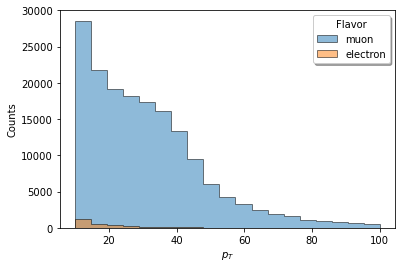

In [4]:
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)
# Now we can start to manipulate this single histogram to plot different views of the data
# here we look at lepton pt for all eta
lepton_pt = lepton_kinematics[:, :, ::sum]

fig, ax = plt.subplots()
lepton_pt.plot1d(
    ax=ax,
    overlay="flavor",
    histtype="fill",
    stack=True,
    alpha=0.5,
    edgecolor=(0, 0, 0, 0.3),
)
# you can edit features of the plot afterwards using matplotlib object-oriented syntax
ax.set_ylabel("Counts")
# e.g. maybe you really miss '90s graphics...
ax.legend(title="Flavor", shadow=True)

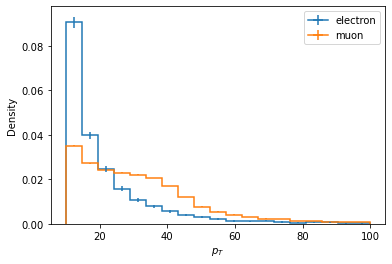

In [5]:
# Clearly the yields are much different, are the shapes similar? We can check by setting `density=True`
lepton_pt.plot1d(overlay="flavor", density=True)
plt.gca().legend()
plt.gca().set_ylabel("Density");

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


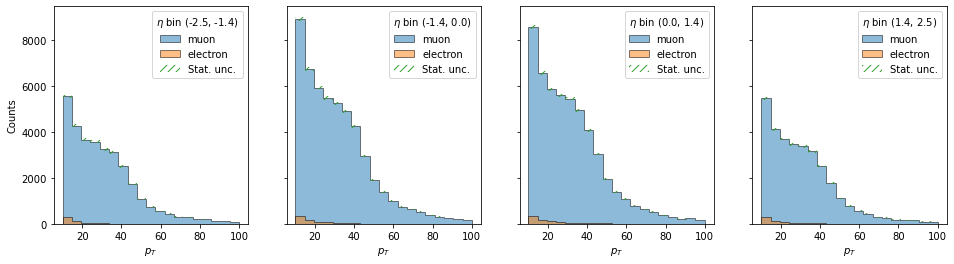

In [6]:
# compare different eta regions
eta_axis = lepton_kinematics.axes[2]
fig, axes = plt.subplots(ncols=len(eta_axis), figsize=(16, 4), sharey=True)
for i, ax in enumerate(axes):
    print(type(ax))
    lepton_kinematics[:, :, i].plot1d(ax=ax, stack=True, histtype="fill", alpha=0.5, edgecolor=(0, 0, 0, 0.3))
    # create a total statistical uncertainty hatch
    tot = lepton_kinematics[::sum, :, i].view()
    ax.stairs(
        edges=lepton_kinematics.axes[1].edges,
        baseline=tot - np.sqrt(tot),
        values=tot + np.sqrt(tot),
        hatch="///",
        label="Stat. unc.",
        facecolor="none",
        linewidth=0,
    )
    ax.legend(title=f"$\eta$ bin {eta_axis[i]}")
    if i == 0:
        ax.set_ylabel("Counts")

In [7]:
# Here we create some pseudodata for the pt histogram so we can make a nice data/mc plot
total = lepton_pt[::sum, :]
data = total.copy()
data.reset()
data.fill(
    np.repeat(total.axes[0].centers, np.random.poisson(total.view()))
)
data

Hist(Regular(19, 10, 100, name='pt', label='$p_{T}$'), storage=Double()) # Sum: 166981.0

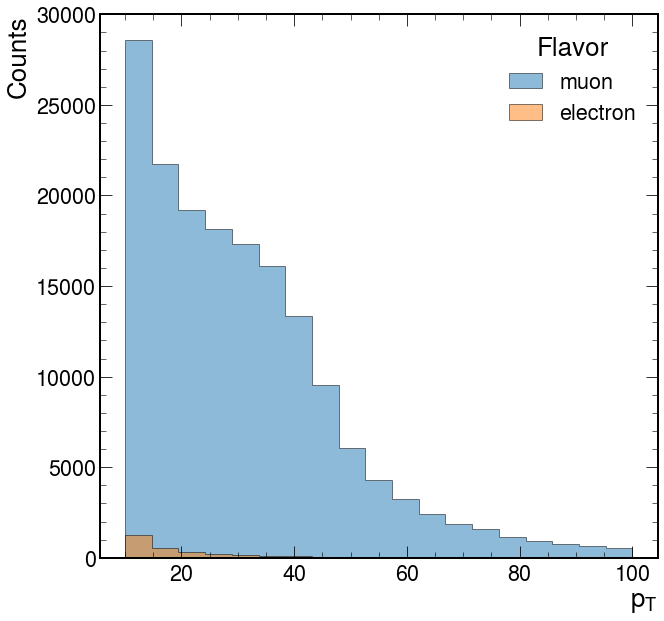

In [8]:
import mplhep
plt.style.use(mplhep.style.CMS)

# Compare this to the style of the plot drawn previously
fig, ax = plt.subplots()
lepton_pt.plot1d(
    ax=ax,
    overlay="flavor",
    histtype="fill",
    stack=True,
    alpha=0.5,
    edgecolor=(0, 0, 0, 0.3),
)
ax.set_ylabel("Counts")
ax.legend(title="Flavor")

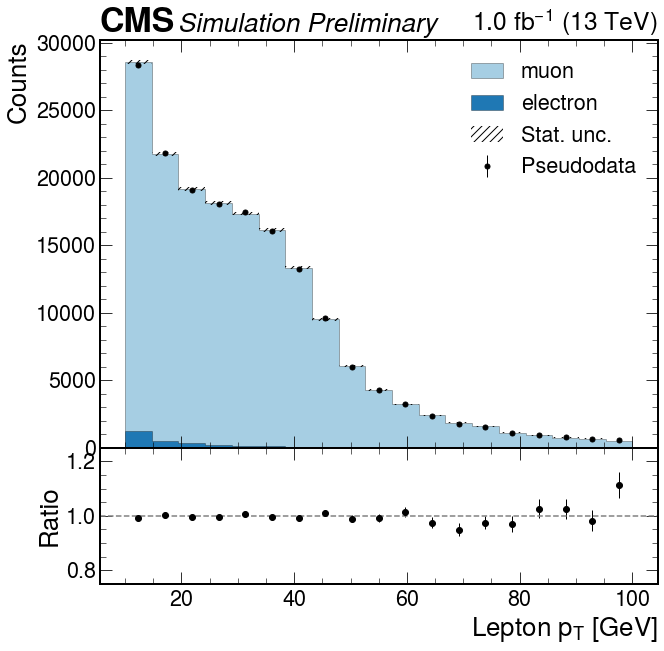

In [9]:
# define a ratio plot figure
fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0), sharex=True)

# Here is an example of setting up a color cycler to color the various fill patches
# We get the colors from this useful utility: http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
from cycler import cycler
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
ax.set_prop_cycle(cycler(color=colors))

# draw components
components = lepton_pt.plot1d(
    ax=ax,
    stack=True,
    histtype="fill",
    edgecolor=(0, 0, 0, 0.3),
)

# create a total statistical uncertainty hatch
ax.stairs(
    edges=lepton_kinematics.axes[1].edges,
    baseline=total - np.sqrt(total),
    values=total + np.sqrt(total),
    hatch="///",
    label="Stat. unc.",
    facecolor="none",
    linewidth=0,
    color="black",
)

data.plot1d(ax=ax, histtype="errorbar", color="k", label="Pseudodata")

ax.set_ylabel("Counts")
ax.legend()

# now draw a ratio plot
from hist.intervals import ratio_uncertainty

rax.errorbar(
    x=data.axes[0].centers,
    y=data.view() / total.view(),
    yerr=ratio_uncertainty(data.view(), total.view(), "poisson"),
    color="k",
    linestyle="none",
    marker="o",
    elinewidth=1,
)
rax.axhline(y=1.0, linestyle="dashed", color="gray")
rax.set_ylabel("Ratio", loc="center")
rax.set_ylim(0.75, 1.25)
rax.set_xlabel("Lepton $p_{T}$ [GeV]")

# add some labels
lumi = mplhep.cms.label(ax=ax, lumi=1.0, label="Preliminary")